# Introdução

Vamos construir uma alternativa aos simuladores eletromagnéticos. Dessa forma, nossa entrada serão as dimensões geométricas da antena, enquanto que a nossa predição será sobre algumas características da antena. Tendo isso em mente, temos um problema de regressão.

## Variáveis independentes

![Célula unitária SRR](https://uo1u3g.by.files.1drv.com/y4mxDEcz91qGqkdsD4XtYtNiPOKAvOJDjNUN_Q-xW8GMwGEVqyK-Qgh4QFodlRXxT6qcMFWLFg1PR73p5lZxtLQcANRhjosXLiqq-21GMlMBVES5sXyVb46oGPIyrIZ_IV-IJrS30os0aehUln1Eum4r78-QtZ-N39G9VW5f5yZUY__EzCT9-lLKgdPzlfSqJJ8mHFZKoZJvjJFND_1q8KoTA?width=256&height=214&cropmode=none)

Sobre as variáveis da célula unitária:

*   **`Wm`** - Altura da célula SRR quadrada (em mm)
*   **`W0m`** - *Gap* dos anéis (em mm)
*   **`dm`** - Distância entre os anéis (em mm)
*   **`tm`** - Espessura dos anéis (em mm)

![Arranjo na antena](https://sp2bga.by.files.1drv.com/y4m3lL2gnN8MtyZlc7TJ9SUIBnIQnJFR5rK1YHChA2CC1P746C87Eerm_TdngTHT01ecZUdm1cwR8Bc3sF29N_iO-r1UkyhpQlRrnQZL7AVgCUwqeNmMh3WJ59pAgVSC1SJrKADPPwLeZiIgQ9l_khGUuHrKb3b46RgPoLQmT_Qw2Of_jGeKyw-aCvEaZ9Du8aLHG21WAfX3M-Tv2pVLfmeGw?width=238&height=256&cropmode=none)

Sobre as variáveis do arranjo:

*   **`Xa`** - Distância em X do arranjo até o *patch* (em mm)
*   **`Ya`** - Distância em Y entre as células do arranjo (em mm)
*   **`rows`** - Quantidade de células no arranjo (de cada lado)

## Variáveis dependentes

*   **`gain`** - ganho da antena (em dB)
*   **`bandwidth`** - largura de banda (em MHz)
*   **`s`** - perda por retorno (em dB)


# Importando os dados e as bibliotecas


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

url = "drive/My Drive/antenna.csv"

Mounted at /content/drive


In [0]:
data = pd.read_csv(url)

data.head()

,Wm,W0m,dm,tm,rows,Xa,Ya,gain,vswr,bandwidth,s,pr,p0
0,2142.9,162.86,77.143,214.29,3.0,0.0,2142.9,2.799175,1.372040,110.6698,-16.090654,0.204248,0.483952
1,2142.9,162.86,77.143,214.29,3.0,3543.5,6964.3,2.817305,1.638103,120.7497,-12.328015,0.197374,0.464289
2,2142.9,162.86,351.430,214.29,5.0,8365.0,6964.3,2.941413,1.242714,123.6901,-19.313586,0.212885,0.490808
3,2142.9,162.86,351.430,214.29,3.0,8365.0,2142.9,2.844078,1.242587,122.4301,-19.317644,0.212405,0.496603
4,2142.9,162.86,351.430,214.29,3.0,8365.0,6964.3,2.812315,1.271176,124.3198,-18.459992,0.207997,0.489240


# Limpeza e preparação dos dados

In [0]:
data.columns

Index(['Wm', 'W0m', 'dm', 'tm', 'rows', 'Xa', 'Ya', 'gain', 'vswr',
       'bandwidth', 's', 'pr', 'p0'],
      dtype='object')

In [0]:
data.shape

(572, 13)

In [0]:
data.describe()

,Wm,W0m,dm,tm,rows,Xa,Ya,gain,vswr,bandwidth,s,pr,p0
count,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,572.000000,509.000000,572.000000,572.000000,572.000000
mean,2244.048252,400.594178,275.425776,224.404825,4.097902,4063.246329,6947.469755,2.678568,2.094927,118.036075,-16.104948,0.192872,0.456955
std,691.578895,184.905214,150.901130,69.157890,1.443942,3287.862064,5136.193313,0.683242,1.914750,11.553491,7.897142,0.046994,0.089213
min,2142.900000,162.860000,77.143000,214.290000,3.000000,0.000000,2142.900000,-5.654378,1.041183,32.759900,-33.903172,0.037383,0.186297
25%,2142.900000,162.860000,77.143000,214.290000,3.000000,1132.800000,2142.900000,2.815006,1.187911,119.490100,-21.321550,0.200121,0.470947
50%,2142.900000,325.710000,214.290000,214.290000,3.000000,3543.500000,6964.300000,2.876220,1.438023,122.220100,-14.910812,0.211927,0.490360
75%,2142.900000,488.570000,351.430000,214.290000,5.000000,5954.300000,11786.000000,2.921877,1.725260,123.269800,-11.498286,0.214335,0.497100
max,6964.300000,651.430000,488.570000,696.430000,7.000000,10776.000000,16607.000000,3.238539,8.377999,124.740100,-2.083432,0.229538,0.499826


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 13 columns):
Wm           572 non-null float64
W0m          572 non-null float64
dm           572 non-null float64
tm           572 non-null float64
rows         572 non-null float64
Xa           572 non-null float64
Ya           572 non-null float64
gain         572 non-null float64
vswr         572 non-null float64
bandwidth    509 non-null float64
s            572 non-null float64
pr           572 non-null float64
p0           572 non-null float64
dtypes: float64(13)
memory usage: 58.2 KB


Aquelas simulações que não possuem `bandwidth` significam que a antena utilizada não ressoa (não funciona) na frequência adotada.

Dessa forma, vamos limpar os valores nulos.

## Limpando os valores nulos

A estratégia aqui é descartar toda linha que não possui `bandwidth`.

In [0]:
data = data.dropna()

In [0]:
data.shape

(509, 13)

# Separação dos dados



Inicialmente, queremos passar as dimensões físicas de uma antena e obter suas respectivas especificações finais.

Separando as colunas *features* (X) das *targets* (Y). 

In [0]:
X_columns = ['Wm', 'W0m', 'dm', 'tm', 'Xa', 'Ya', 'rows']
y_columns = ['gain', 'bandwidth', 's']

X = data[X_columns]
y = data[y_columns]

# Construindo um modelo para o ganho

Vamos separar `gain` de `y`:

In [0]:
gain = y['gain']

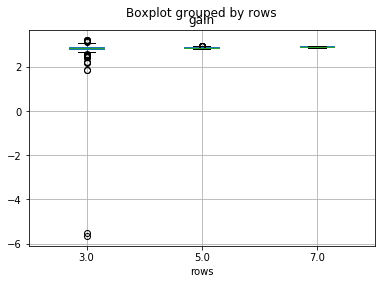

In [0]:
data.boxplot('gain', 'rows')
plt.show()

Aqui podemos ver alguns *outliers* quando temos 3 `rows`. Esse tipo de informação não é útil e muitas vezes acaba atrapalhando a modelagem. Vamos remover as linhas que não satisfazem a condição `gain > 0`.

In [0]:
X = X[gain > 0]
gain = gain[gain > 0]

Checando a variância das features, temos:

In [0]:
print(X.var())

Wm      3.171436e+05
W0m     3.427141e+04
dm      2.280619e+04
tm      3.171436e+03
Xa      9.805929e+06
Ya      2.821793e+07
rows    1.998020e+00
dtype: float64


É possível observar que a variância de todas as features, exceto `rows`, é bem alta. Isso é sinal de que teremos que normalizar os dados antes da modelagem.

### Seleção de feature

Verificando qual feature tem mais impacto sobre o ganho através do algoritmo `Lasso Regression`, temos:

O melhor alpha para o Lasso do ganho é 0.0002


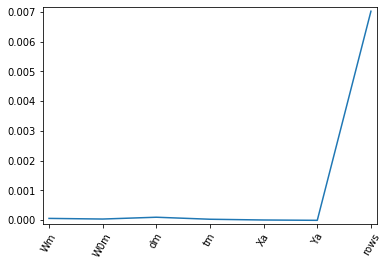

In [0]:
# Perform hyperparameter tuning on lasso regression
param_grid = {'alpha': np.arange(1e-4, 1e-3, 1e-4)}

lasso = Lasso(normalize=True)

lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X, gain)

# Set best alpha
print('O melhor alpha para o Lasso do ganho é {}'.format(lasso_cv.best_params_['alpha']))
lasso.alpha = lasso_cv.best_params_['alpha']
lasso.fit(X, gain)

# Get coeficients from Lasso
lasso_coef = lasso.coef_

plt.plot(range(len(X_columns)), lasso_coef)
plt.xticks(range(len(X_columns)), X_columns, rotation=60)
plt.margins(0.02)
plt.show()

Parece que a feature `rows` é que a que tem mais impacto sobre o ganho. É possível ver que essas duas variáveis possuem uma relação diretamente proporcional. Também é possível observar a mínima relação com `Wm`. Traduzindo, temos dois *insights* para o ganho: 

*   Quanto mais células SRR no arranjo, maior o ganho.
*   Quanto menor a altura da célula SRR quadrada, maior o ganho.

### Treinamento do modelo

Finalmente, vamos construir uma pipeline com os seguintes passos:
 - `Scaler` para unificar a escala dos dados
 - `KNeighborsRegressor` como algoritmo de regressão

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, gain, random_state=42)

# steps for the pipeline
steps = [('normalizer', Normalizer()), # normalization to lower variance
         ('scaler', StandardScaler()), # set features on the same scale
         ('knn', KNeighborsRegressor())]
pipeline = Pipeline(steps)

# params for the cross-validation
param_grid = {'knn__n_neighbors': np.arange(1, 8)}

cv = GridSearchCV(pipeline, param_grid)
cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print('Melhores parâmetros: {}'.format(cv.best_params_))
print('R^2: {}'.format(cv.score(X_test, y_test)))
print('np.mean(R^2): {}'.format(mean_squared_error(y_test, y_pred)))

Melhores parâmetros: {'knn__n_neighbors': 1}
R^2: 0.7708413831601835
np.mean(R^2): 0.003626464389707951


Salvando o melhor modelo:

In [0]:
gain_best = cv.best_estimator_

# Construindo um modelo para a perda por retorno

Vamos separar `s` de `y`:

In [0]:
X = data[X_columns]
s = y['s']

In [0]:
print(s.shape, X.shape)

(509,) (509, 7)


### Treinamento do modelo

Utilizando novamente `KNeighborsRegressor` como modelo preditivo, temos:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, s, random_state=42)

steps = [('normalizer', Normalizer()),
         ('scaler', StandardScaler()),
         ('knn', KNeighborsRegressor())]
pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1, 8)}

cv = GridSearchCV(pipeline, param_grid)
cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print('Melhores parâmetros: {}'.format(cv.best_params_))
print('R^2: {}'.format(cv.score(X_test, y_test)))
print('np.mean(R^2): {}'.format(mean_squared_error(y_test, y_pred)))

Melhores parâmetros: {'knn__n_neighbors': 2}
R^2: 0.9438547673940144
np.mean(R^2): 2.4539014474879512


Salvando o melhor modelo:

In [0]:
s_best = cv.best_estimator_

# Construindo um modelo para a largura de banda

Vamos separar `bandwidth` de `y`:

In [0]:
bandwidth = y['bandwidth']

Encerrando com `KNeighborsRegressor`:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, bandwidth, random_state=42)

steps = [('normalizer', Normalizer()),
         ('scaler', StandardScaler()),
         ('knn', KNeighborsRegressor())]
pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1, 8)}

cv = GridSearchCV(pipeline, param_grid)
cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)

print('Melhores parâmetros: {}'.format(cv.best_params_))
print('R^2: {}'.format(cv.score(X_test, y_test)))
print('np.mean(R^2): {}'.format(mean_squared_error(y_test, y_pred)))

Melhores parâmetros: {'knn__n_neighbors': 2}
R^2: 0.8781878882090125
np.mean(R^2): 15.612865834843792


Salvando o melhor modelo:

In [0]:
bandwidth_best = cv.best_estimator_